# Basic classification: Classify images of clothing
A tensorflow serving style service example using BentoML


![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=tensorflow&ea=tensorflow_2_fashion_mnist&dt=tensorflow_2_fashion_mnist)

In [14]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [15]:
from __future__ import absolute_import, division, print_function, unicode_literals

import io

# TensorFlow
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


In [16]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(_train_images, train_labels), (_test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
train_images = _train_images / 255.0
test_images = _test_images / 255.0

In [17]:
class FashionMnist(tf.keras.Model):
    def __init__(self):
        super(FashionMnist, self).__init__()
        self.cnn = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')
        ])
    
    @staticmethod
    def image_bytes2tensor(inputs):
        inputs = tf.map_fn(lambda i: tf.io.decode_png(i, channels=1), inputs, dtype=tf.uint8)
        inputs = tf.cast(inputs, tf.float32)
        inputs = (255.0 - inputs) / 255.0
        inputs = tf.reshape(inputs, [-1, 28, 28])
        return inputs

    @tf.function
    def predict_image(self, inputs):
        inputs = self.image_bytes2tensor(inputs)
        return self(inputs)
    
    def call(self, inputs):
        return self.cnn(inputs)


## test the image preprocessing

Ankle boot


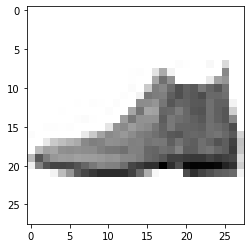

In [18]:
# pick up a test image
d_test_img = _test_images[0]
print(class_names[test_labels[0]])

plt.imshow(255.0 - d_test_img, cmap='gray')
plt.imsave("test.png", 255.0 - d_test_img, cmap='gray')

# read bytes
with open("test.png", "rb") as f:
    img_bytes = f.read()

# verify saved image
assert tf.reduce_mean(FashionMnist.image_bytes2tensor(tf.constant([img_bytes])) - d_test_img) < 0.01

## train the model


In [19]:
model = FashionMnist()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=1)

Train on 60000 samples
60000/60000 [==============================] - 3s 58us/sample - loss: 0.4996 - accuracy: 0.8253


## test the model

In [20]:
predict = model.predict_image(tf.constant([img_bytes]))
klass = tf.argmax(predict, axis=1)[0]
class_names[klass]

'Ankle boot'

And the model predicts a label as expected.

# Define & save BentoService

In [21]:
%%writefile tensorflow_fashion_mnist.py

import bentoml
import tensorflow as tf
import numpy as np
from PIL import Image

from bentoml.artifact import (
    TensorflowSavedModelArtifact,
)
from bentoml.handlers import TensorflowTensorHandler


FASHION_MNIST_CLASSES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


@bentoml.env(pip_dependencies=['tensorflow', 'numpy', 'pillow'])
@bentoml.artifacts([TensorflowSavedModelArtifact('model')])
class FashionMnistTensorflow(bentoml.BentoService):

    @bentoml.api(TensorflowTensorHandler)
    def predict(self, inputs):
        outputs = self.artifacts.model.predict_image(inputs)
        output_classes = tf.math.argmax(outputs, axis=1)
        return FASHION_MNIST_CLASSES[output_classes[0]]


Overwriting tensorflow_fashion_mnist.py


In [22]:
from tensorflow_fashion_mnist import FashionMnistTensorflow

bento_svc = FashionMnistTensorflow()
bento_svc.pack("model", model)
saved_path = bento_svc.save()


W0124 14:54:09.307845 4577369536 deprecation.py:506] From /usr/local/anaconda3/envs/dev-py3/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1781: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


running sdist
running egg_info
writing BentoML.egg-info/PKG-INFO
writing dependency_links to BentoML.egg-info/dependency_links.txt
writing entry points to BentoML.egg-info/entry_points.txt
writing requirements to BentoML.egg-info/requires.txt
writing top-level names to BentoML.egg-info/top_level.txt
reading manifest file 'BentoML.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'


no previously-included directories found matching 'examples'
no previously-included directories found matching 'tests'
no previously-included directories found matching 'docs'


writing manifest file 'BentoML.egg-info/SOURCES.txt'
running check


creating BentoML-0.6.1
creating BentoML-0.6.1/BentoML.egg-info
creating BentoML-0.6.1/bentoml
creating BentoML-0.6.1/bentoml/artifact
creating BentoML-0.6.1/bentoml/bundler
creating BentoML-0.6.1/bentoml/cli
creating BentoML-0.6.1/bentoml/clipper
creating BentoML-0.6.1/bentoml/configuration
creating BentoML-0.6.1/bentoml/deployment
creating BentoML-0.6.1/bentoml/deployment/aws_lambda
creating BentoML-0.6.1/bentoml/deployment/sagemaker
creating BentoML-0.6.1/bentoml/handlers
creating BentoML-0.6.1/bentoml/migrations
creating BentoML-0.6.1/bentoml/migrations/versions
creating BentoML-0.6.1/bentoml/proto
creating BentoML-0.6.1/bentoml/repository
creating BentoML-0.6.1/bentoml/server
creating BentoML-0.6.1/bentoml/server/static
creating BentoML-0.6.1/bentoml/utils
creating BentoML-0.6.1/bentoml/utils/validator
creating BentoML-0.6.1/bentoml/yatai
creating BentoML-0.6.1/bentoml/yatai/client
copying files to BentoML-0.6.1...
copying LICENSE -> BentoML-0.6.1
copying MANIFEST.in -> BentoML-0.6

copying bentoml/utils/validator/__init__.py -> BentoML-0.6.1/bentoml/utils/validator
copying bentoml/yatai/__init__.py -> BentoML-0.6.1/bentoml/yatai
copying bentoml/yatai/deployment_utils.py -> BentoML-0.6.1/bentoml/yatai
copying bentoml/yatai/status.py -> BentoML-0.6.1/bentoml/yatai
copying bentoml/yatai/yatai_service_impl.py -> BentoML-0.6.1/bentoml/yatai
copying bentoml/yatai/client/__init__.py -> BentoML-0.6.1/bentoml/yatai/client
copying bentoml/yatai/client/bento_repository_api.py -> BentoML-0.6.1/bentoml/yatai/client
copying bentoml/yatai/client/deployment_api.py -> BentoML-0.6.1/bentoml/yatai/client
Writing BentoML-0.6.1/setup.cfg
UPDATING BentoML-0.6.1/bentoml/_version.py
set BentoML-0.6.1/bentoml/_version.py to '0.6.1'
Creating tar archive
removing 'BentoML-0.6.1' (and everything under it)
[2020-01-24 14:54:28,199] INFO - BentoService bundle 'FashionMnistTensorflow:20200124145408_3B6770' created at: /private/var/folders/kn/xnc9k74x03567n1mx2tfqnpr0000gn/T/bentoml-temp-mxqeot

## Use BentoService with BentoML CLI

**`bentoml get <BentoService Name>` list all of BentoService's versions**

In [23]:
!bentoml get FashionMnistTensorflow

BENTO_SERVICE                                 CREATED_AT        APIS                              ARTIFACTS
FashionMnistTensorflow:20200124145408_3B6770  2020-01-24 22:54  predict::TensorflowTensorHandler  model::TensorflowSavedModelArtifact
FashionMnistTensorflow:20200123170321_A5B632  2020-01-24 01:03  predict::TensorflowTensorHandler  model::TensorflowSavedModelArtifact
FashionMnistTensorflow:20200123104656_1FC32A  2020-01-23 18:47  predict::TensorflowTensorHandler  model::TensorflowSavedModelArtifact


**`bentoml get <BentoService name>:<bentoService version>` display detailed information of the specific BentoService version**

In [24]:
!bentoml get FashionMnistTensorflow:20200124145408_3B6770

{
  "name": "FashionMnistTensorflow",
  "version": "20200124145408_3B6770",
  "uri": {
    "type": "LOCAL",
    "uri": "/Users/bozhaoyu/bentoml/repository/FashionMnistTensorflow/20200124145408_3B6770"
  },
  "bentoServiceMetadata": {
    "name": "FashionMnistTensorflow",
    "version": "20200124145408_3B6770",
    "createdAt": "2020-01-24T22:54:26.219770Z",
    "env": {
      "condaEnv": "name: bentoml-FashionMnistTensorflow\nchannels:\n- defaults\ndependencies:\n- python=3.7.3\n- pip\n",
      "pipDependencies": "bentoml==0.6.1\ntensorflow\nnumpy\npillow",
      "pythonVersion": "3.7.3"
    },
    "artifacts": [
      {
        "name": "model",
        "artifactType": "TensorflowSavedModelArtifact"
      }
    ],
    "apis": [
      {
        "name": "predict",
        "handlerType": "TensorflowTensorHandler",
        "docs": "BentoService API"
      }
    ]
  }
}


**Serve bentoml REST server locally**

In [25]:
!bentoml serve {saved_path} --port 8890

2020-01-24 14:59:17.459820: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-01-24 14:59:17.480241: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbefa04a600 executing computations on platform Host. Devices:
2020-01-24 14:59:17.480260: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
 * Serving Flask app "FashionMnistTensorflow" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
I0124 14:59:17.771595 4622708160 _internal.py:122]  * Running on http://127.0.0.1:8890/ (Press CTRL+C to quit)
^C


## query REST API with python

In [26]:
import base64
import json
import requests

with open("test.png", "rb") as f:
    img_bytes = f.read()
img_b64 = base64.b64encode(img_bytes).decode()


headers = {"content-type": "application/json"}
data = json.dumps(
       {"instances": [{"b64": img_b64}]}
)
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

json_response = requests.post(f'http://localhost:8890/predict', data=data, headers=headers)
print(json_response)
print(json_response.text)

Data: {"instances": [{"b64": "iVBORw0KGgoAAAANSUhEUgAAAB ... ufkz8DPG//sD/AX8I8DvdgnOxdB4B1wAAAAASUVORK5CYII="}]}
<Response [200]>
{"predictions": "Ankle boot"}


# Use BentoService as PyPI package

`pip install $SAVED_PATH` also installs a CLI tool for accessing the BentoML service

In [22]:
import os
import sys

kernel_path = f"{sys.exec_prefix}/bin"
local_path = f"{os.environ['HOME']}/.local/bin"

if kernel_path not in os.environ['PATH']:
    os.environ['PATH'] = f"{kernel_path}:{os.environ['PATH']}"

if local_path not in os.environ['PATH']:
    os.environ['PATH'] = f"{local_path}:{os.environ['PATH']}"

!which pip

/opt/anaconda3/envs/bentoml-dev/bin/pip


In [17]:
!pip install {saved_path}

Processing /Users/bozhaoyu/bentoml/repository/FashionMnistTensorflow/20200123104656_1FC32A


  Created wheel for FashionMnistTensorflow: filename=FashionMnistTensorflow-20200123104656_1FC32A-cp37-none-any.whl size=1275731 sha256=f0fdef83f61bca3be9d157b5a49c862bde03eb68199c923be3edcccbba2b628e
  Stored in directory: /private/var/folders/kn/xnc9k74x03567n1mx2tfqnpr0000gn/T/pip-ephem-wheel-cache-rz7um0mb/wheels/3e/ab/28/0bafdaa7cd565a3939bd8a7b20bfae9ba76ee5268a5eb7659d
Successfully built FashionMnistTensorflow
  Found existing installation: FashionMnistTensorflow 20200123104656-1FC32A
    Uninstalling FashionMnistTensorflow-20200123104656-1FC32A:
      Successfully uninstalled FashionMnistTensorflow-20200123104656-1FC32A


In [18]:
!FashionMnistTensorflow info

{
  "name": "FashionMnistTensorflow",
  "version": "20200123104656_1FC32A",
  "created_at": "2020-01-23T18:47:16.739499Z",
  "env": {
    "conda_env": "name: bentoml-FashionMnistTensorflow\nchannels:\n- defaults\ndependencies:\n- python=3.7.3\n- pip\n",
    "pip_dependencies": "bentoml==0.6.0\ntensorflow\nnumpy",
    "python_version": "3.7.3"
  },
  "artifacts": [
    {
      "name": "model",
      "artifact_type": "TensorflowSavedModelArtifact"
    }
  ],
  "apis": [
    {
      "name": "predict",
      "handler_type": "TensorflowTensorHandler",
      "docs": "BentoService API"
    }
  ]
}


### Run 'predict' api with json data:

In [24]:
!echo '{\"instances\":[{\"b64\":\"'$(base64 test.png)'\"}]}' > test.json
!cat test.json | xargs -I {} FashionMNISTServicer predict --input={}

[2019-12-21 13:52:09,960] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.5.2. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml_deploy_version' to a pinned version or your custom BentoML on github, e.g.:'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2019-12-21 13:52:09,969] WARNING - Saved BentoService bundle version mismatch: loading BentoServie bundle create with BentoML version 0.5.2,  but loading from BentoML version 0.5.2+38.g5342a8b
[2019-12-21 13:52:09,971] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will b

## Build realtime prediction service in docker with BentoService

In [9]:
!cd {saved_path} && docker build -t tensorflow2-fashion-mnist .

Sending build context to Docker daemon  2.341MB
Step 1/12 : FROM continuumio/miniconda3:4.7.12
 ---> 406f2b43ea59
Step 2/12 : ENTRYPOINT [ "/bin/bash", "-c" ]
 ---> Running in a67c0f76a684
Removing intermediate container a67c0f76a684
 ---> 28172be83c07
Step 3/12 : EXPOSE 5000
 ---> Running in b3dd42abcc6a
Removing intermediate container b3dd42abcc6a
 ---> 840844d191d4
Step 4/12 : RUN set -x      && apt-get update      && apt-get install --no-install-recommends --no-install-suggests -y libpq-dev build-essential      && rm -rf /var/lib/apt/lists/*
 ---> Running in d695159416dc
+ apt-get update
Get:1 http://security.debian.org/debian-security buster/updates InRelease [65.4 kB]
Get:2 http://deb.debian.org/debian buster InRelease [122 kB]
Get:3 http://deb.debian.org/debian buster-updates InRelease [49.3 kB]
Get:4 http://security.debian.org/debian-security buster/updates/main amd64 Packages [174 kB]
Get:5 http://deb.debian.org/debian buster/main amd64 Packages [7908 kB]
Fetched 8318 kB in 2s

Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../15-libatomic1_8.3.0-6_amd64.deb ...
Unpacking libatomic1:amd64 (8.3.0-6) ...
Selecting previously unselected package libasan5:amd64.
Preparing to unpack .../16-libasan5_8.3.0-6_amd64.deb ...
Unpacking libasan5:amd64 (8.3.0-6) ...
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../17-liblsan0_8.3.0-6_amd64.deb ...
Unpacking liblsan0:amd64 (8.3.0-6) ...
Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../18-libtsan0_8.3.0-6_amd64.deb ...
Unpacking libtsan0:amd64 (8.3.0-6) ...
Selecting previously unselected package libubsan1:amd64.
Preparing to unpack .../19-libubsan1_8.3.0-6_amd64.deb ...
Unpacking libubsan1:amd64 (8.3.0-6) ...
Selecting previously unselected package libmpx2:amd64.
Preparing to unpack .../20-libmpx2_8.3.0-6_amd64.deb ...
Unpacking libmpx2:amd64 (8.3.0-6) ...
Selecting previously unselected package libquadmath0:amd64.
Preparing to unp

  Created wheel for tabulate: filename=tabulate-0.8.6-cp37-none-any.whl size=23274 sha256=211333effc4d6ac24e32a49642a726a6fa422c259e131edce35f19545d617476
  Stored in directory: /root/.cache/pip/wheels/9c/9b/f4/eb243fdb89676ec00588e8c54bb54360724c06e7fafe95278e
  Created wheel for sqlalchemy: filename=SQLAlchemy-1.3.13-cp37-cp37m-linux_x86_64.whl size=1223704 sha256=f60318909f180cf0bd6574f35f9f39e881c5ad00a9b0aa54a981c0e44d70b6bf
  Stored in directory: /root/.cache/pip/wheels/b3/35/98/4c9cb3fd63d21d5606b972dd70643769745adf60e622467b71
  Created wheel for alembic: filename=alembic-1.3.3-py2.py3-none-any.whl size=155684 sha256=0fa9d37e6ed76b51afd150ba9dc51fcb812d7d930f0aaf5d7f1dc85405efafa6
  Stored in directory: /root/.cache/pip/wheels/12/6a/49/94a4af65af2edbccf9f467c0f4b26f24d0e5b61be0d8a7e066
  Created wheel for cerberus: filename=Cerberus-1.3.2-cp37-none-any.whl size=54336 sha256=9b83ffeb4db60da5f9a21455ef5501c33bf92235da5a74ed8eaf661a06d9ab7f
  Stored in directory: /root/.cache/pip/

  Created wheel for prometheus-client: filename=prometheus_client-0.7.1-cp37-none-any.whl size=41402 sha256=5d2cbfea526905dbef0009b8d0d6466d5cdc480fdaf82ddff026353591ac82a8
  Stored in directory: /root/.cache/pip/wheels/1c/54/34/fd47cd9b308826cc4292b54449c1899a30251ef3b506bc91ea
  Created wheel for termcolor: filename=termcolor-1.1.0-cp37-none-any.whl size=4832 sha256=1af3e513cc22a6fe4bc924a326066264b755968c094c28415c064e7a8fcee06a
  Stored in directory: /root/.cache/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Created wheel for opt-einsum: filename=opt_einsum-3.1.0-cp37-none-any.whl size=61682 sha256=691e70132231ff69eaf671add6d001c0b81715748b86c5dce3426e03464aa75e
  Stored in directory: /root/.cache/pip/wheels/2c/b1/94/43d03e130b929aae7ba3f8d15cbd7bc0d1cb5bb38a5c721833
  Created wheel for absl-py: filename=absl_py-0.9.0-cp37-none-any.whl size=121932 sha256=c5109ed760eb9932a0bdb4da6a31fdfd77d647edc70db43be62d2b29ca6922e2
  Stored in directory: /root/.cache/p

  Created wheel for BentoML: filename=BentoML-0.6.0-cp37-none-any.whl size=505613 sha256=dd5857ba108ad02f61fc6148221e129eee22f564ed4c11b2d71f79bec61f4b33
  Stored in directory: /root/.cache/pip/wheels/18/42/e5/7aade3a0ee2b7f6405b1751a9d08ca5d884cc501f6c2d72784
Successfully built BentoML
  Found existing installation: BentoML 0.6.0
    Uninstalling BentoML-0.6.0:
      Successfully uninstalled BentoML-0.6.0
Removing intermediate container 8ecbd88b832b
 ---> a4c7e0690847
Step 12/12 : CMD ["bentoml serve-gunicorn /bento"]
 ---> Running in 321a20b6588a
Removing intermediate container 321a20b6588a
 ---> 23eb9647b787
Successfully built 23eb9647b787
Successfully tagged tensorflow2-fashion-mnist:latest


In [ ]:
!docker run -p 5000:5000 tensorflow2-fashion-mnist

# Additional: serve with tf-serving

In [ ]:
TMP_MODEL_DIR = "/tmp/test-model/"
SERVE_HOST = "http://localhost:8890"
SERVE_PORT = 8890
MODEL_NAME = "fashion_model"
tf.saved_model.save(model, TMP_MODEL_DIR)
!tensorflow_model_server --rest_api_port={SERVE_PORT} --model_name={MODEL_NAME} --model_base_path={TMP_MODEL_DIR}

# Deploy BentoService as REST API server to the cloud


BentoML support deployment to multiply cloud provider services, such as AWS Lambda, AWS Sagemaker, Google Cloudrun and etc. You can find the full list and guide on the documentation site at https://docs.bentoml.org/en/latest/deployment/index.html

For this demo, we are going to deploy to AWS Sagemaker

In [26]:
bento_service_tag = f'{bento_svc.name}:{bento_svc.version}'
print(bento_service_tag)

FashionMnistTensorflow:20200124145408_3B6770


In [27]:
!bentoml sagemaker deploy first-tf-fashion -b {bento_service_tag} --api-name predict --verbose

[2020-01-24 14:59:44,666] DEBUG - Using BentoML with local Yatai server
[2020-01-24 14:59:44,808] DEBUG - Upgrading tables to the latest revision
Deploying Sagemaker deployment /[2020-01-24 14:59:45,814] DEBUG - Created temporary directory: /private/var/folders/kn/xnc9k74x03567n1mx2tfqnpr0000gn/T/bentoml-temp-esk46k3d
-[2020-01-24 14:59:46,092] DEBUG - Getting docker login info from AWS
[2020-01-24 14:59:46,093] DEBUG - Building docker image: 192023623294.dkr.ecr.us-west-2.amazonaws.com/fashionmnisttensorflow-sagemaker:20200124145408_3B6770
-[2020-01-24 14:59:46,532] INFO - Step 1/11 : FROM continuumio/miniconda3:4.7.12
[2020-01-24 14:59:46,533] INFO - 

[2020-01-24 14:59:46,533] INFO -  ---> 406f2b43ea59

[2020-01-24 14:59:46,533] INFO - Step 2/11 : EXPOSE 8080
[2020-01-24 14:59:46,533] INFO - 

[2020-01-24 14:59:46,533] INFO -  ---> Using cache

[2020-01-24 14:59:46,533] INFO -  ---> 7c8096d6922f

[2020-01-24 14:59:46,533] INFO - Step 3/11 : RUN set -x      && apt-get update      &

/[2020-01-24 15:01:25,261] INFO - Collecting python-json-logger

[2020-01-24 15:01:25,281] INFO -   Downloading https://files.pythonhosted.org/packages/80/9d/1c3393a6067716e04e6fcef95104c8426d262b4adaf18d7aa2470eab028d/python-json-logger-0.1.11.tar.gz

/[2020-01-24 15:01:25,667] INFO - Requirement already satisfied: gunicorn in /opt/conda/lib/python3.7/site-packages (from bentoml==0.6.1->-r /opt/program/requirements.txt (line 1)) (20.0.4)

|[2020-01-24 15:01:25,833] INFO - Collecting docker

\[2020-01-24 15:01:25,866] INFO -   Downloading https://files.pythonhosted.org/packages/cc/ca/699d4754a932787ef353a157ada74efd1ceb6d1fc0bfb7989ae1e7b33111/docker-4.1.0-py2.py3-none-any.whl (139kB)

\[2020-01-24 15:01:26,754] INFO - Collecting grpcio

[2020-01-24 15:01:26,780] INFO -   Downloading https://files.pythonhosted.org/packages/bc/b3/0052e38c640d52b710e235b15821cc3c61d0065bf54e70a44550ef127349/grpcio-1.26.0-cp37-cp37m-manylinux2010_x86_64.whl (2.4MB)

|[2020-01-24 15:01:27,006] INFO -

|[2020-01-24 15:01:41,076] INFO - Requirement already satisfied: setuptools in /opt/conda/lib/python3.7/site-packages (from protobuf>=3.6.0->bentoml==0.6.1->-r /opt/program/requirements.txt (line 1)) (41.4.0)

\[2020-01-24 15:01:41,159] INFO - Collecting ruamel.yaml.clib>=0.1.2; platform_python_implementation == "CPython" and python_version < "3.8"

[2020-01-24 15:01:41,187] INFO -   Downloading https://files.pythonhosted.org/packages/40/80/da16b691d5e259dd9919a10628e541fca321cb4b078fbb88e1c7c22aa42d/ruamel.yaml.clib-0.2.0-cp37-cp37m-manylinux1_x86_64.whl (547kB)

/[2020-01-24 15:01:41,414] INFO - Collecting pyparsing>=2.0.2

[2020-01-24 15:01:41,437] INFO -   Downloading https://files.pythonhosted.org/packages/5d/bc/1e58593167fade7b544bfe9502a26dc860940a79ab306e651e7f13be68c2/pyparsing-2.4.6-py2.py3-none-any.whl (67kB)

|[2020-01-24 15:01:41,542] INFO - Collecting websocket-client>=0.32.0

\[2020-01-24 15:01:41,565] INFO -   Downloading https://files.pythonhosted.org/packages/4c/

-[2020-01-24 15:01:49,993] INFO -   Building wheel for gast (setup.py): finished with status 'done'

[2020-01-24 15:01:49,994] INFO -   Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=f2d4d830f40a398e71a080d92c0910fb7c5f57e50e64084bb9d44bfffc2c373b

[2020-01-24 15:01:49,995] INFO -   Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd

[2020-01-24 15:01:50,002] INFO -   Building wheel for termcolor (setup.py): started

/[2020-01-24 15:01:50,438] INFO -   Building wheel for termcolor (setup.py): finished with status 'done'

[2020-01-24 15:01:50,439] INFO -   Created wheel for termcolor: filename=termcolor-1.1.0-cp37-none-any.whl size=4832 sha256=edc74ba5cd8e148a17fa76b2817552208b3e294682704fab3c2202d79effeaf7

[2020-01-24 15:01:50,440] INFO -   Stored in directory: /root/.cache/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6

[2020-01-24 15:01:50,446] INFO -   Building wheel for 

[2020-01-24 15:08:45,699] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-first-tf-fashion', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-first-tf-fashion', 'EndpointConfigName': 'dev-first-tf-fas-FashionMnistTensorflow-20200124145408-3B6770', 'EndpointStatus': 'Creating', 'CreationTime': datetime.datetime(2020, 1, 24, 15, 8, 46, 337000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 1, 24, 15, 8, 46, 337000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': '23847573-0dd7-4373-a807-c19895e4429b', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '23847573-0dd7-4373-a807-c19895e4429b', 'content-type': 'application/x-amz-json-1.1', 'content-length': '307', 'date': 'Fri, 24 Jan 2020 23:08:46 GMT'}, 'RetryAttempts': 0}}
\[2020-01-24 15:08:50,943] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-first-tf-fashion', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-first-tf-fashion', 'Endpoin

-[2020-01-24 15:09:43,233] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-first-tf-fashion', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-first-tf-fashion', 'EndpointConfigName': 'dev-first-tf-fas-FashionMnistTensorflow-20200124145408-3B6770', 'EndpointStatus': 'Creating', 'CreationTime': datetime.datetime(2020, 1, 24, 15, 8, 46, 337000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 1, 24, 15, 8, 46, 337000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': '71546378-cd10-4d4a-a801-440346a8e147', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '71546378-cd10-4d4a-a801-440346a8e147', 'content-type': 'application/x-amz-json-1.1', 'content-length': '307', 'date': 'Fri, 24 Jan 2020 23:09:43 GMT'}, 'RetryAttempts': 0}}
\[2020-01-24 15:09:48,435] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-first-tf-fashion', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-first-tf-fashion', 'Endpo

-[2020-01-24 15:10:41,207] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-first-tf-fashion', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-first-tf-fashion', 'EndpointConfigName': 'dev-first-tf-fas-FashionMnistTensorflow-20200124145408-3B6770', 'EndpointStatus': 'Creating', 'CreationTime': datetime.datetime(2020, 1, 24, 15, 8, 46, 337000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 1, 24, 15, 8, 46, 337000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': '5e61340d-9fc5-42cf-aa12-a6fbc387cb27', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '5e61340d-9fc5-42cf-aa12-a6fbc387cb27', 'content-type': 'application/x-amz-json-1.1', 'content-length': '307', 'date': 'Fri, 24 Jan 2020 23:10:42 GMT'}, 'RetryAttempts': 0}}
-[2020-01-24 15:10:46,650] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-first-tf-fashion', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-first-tf-fashion', 'Endpo

-[2020-01-24 15:11:40,142] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-first-tf-fashion', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-first-tf-fashion', 'EndpointConfigName': 'dev-first-tf-fas-FashionMnistTensorflow-20200124145408-3B6770', 'EndpointStatus': 'Creating', 'CreationTime': datetime.datetime(2020, 1, 24, 15, 8, 46, 337000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 1, 24, 15, 8, 46, 337000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': 'f0d0ccd8-d20c-4e94-906c-45da62a150e9', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'f0d0ccd8-d20c-4e94-906c-45da62a150e9', 'content-type': 'application/x-amz-json-1.1', 'content-length': '307', 'date': 'Fri, 24 Jan 2020 23:11:40 GMT'}, 'RetryAttempts': 0}}
/[2020-01-24 15:11:45,499] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-first-tf-fashion', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-first-tf-fashion', 'Endpo

|[2020-01-24 15:12:38,221] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-first-tf-fashion', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-first-tf-fashion', 'EndpointConfigName': 'dev-first-tf-fas-FashionMnistTensorflow-20200124145408-3B6770', 'EndpointStatus': 'Creating', 'CreationTime': datetime.datetime(2020, 1, 24, 15, 8, 46, 337000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 1, 24, 15, 8, 46, 337000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': '79d32617-d4a0-4e15-8d92-99cb0d96469a', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '79d32617-d4a0-4e15-8d92-99cb0d96469a', 'content-type': 'application/x-amz-json-1.1', 'content-length': '307', 'date': 'Fri, 24 Jan 2020 23:12:38 GMT'}, 'RetryAttempts': 0}}
|[2020-01-24 15:12:43,550] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-first-tf-fashion', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-first-tf-fashion', 'Endpo

|[2020-01-24 15:13:36,191] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-first-tf-fashion', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-first-tf-fashion', 'EndpointConfigName': 'dev-first-tf-fas-FashionMnistTensorflow-20200124145408-3B6770', 'EndpointStatus': 'Creating', 'CreationTime': datetime.datetime(2020, 1, 24, 15, 8, 46, 337000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 1, 24, 15, 8, 46, 337000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': 'fe4f83be-971a-495c-87f2-5fb5d73d5e46', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'fe4f83be-971a-495c-87f2-5fb5d73d5e46', 'content-type': 'application/x-amz-json-1.1', 'content-length': '307', 'date': 'Fri, 24 Jan 2020 23:13:36 GMT'}, 'RetryAttempts': 0}}
/[2020-01-24 15:13:41,396] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-first-tf-fashion', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-first-tf-fashion', 'Endpo

/[2020-01-24 15:14:33,525] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-first-tf-fashion', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-first-tf-fashion', 'EndpointConfigName': 'dev-first-tf-fas-FashionMnistTensorflow-20200124145408-3B6770', 'EndpointStatus': 'Creating', 'CreationTime': datetime.datetime(2020, 1, 24, 15, 8, 46, 337000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 1, 24, 15, 8, 46, 337000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': '4a997eca-f803-4f74-a0d1-fcb34b9cd0ff', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '4a997eca-f803-4f74-a0d1-fcb34b9cd0ff', 'content-type': 'application/x-amz-json-1.1', 'content-length': '307', 'date': 'Fri, 24 Jan 2020 23:14:34 GMT'}, 'RetryAttempts': 0}}
-[2020-01-24 15:14:38,741] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-first-tf-fashion', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-first-tf-fashion', 'Endpo

|[2020-01-24 15:15:31,269] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-first-tf-fashion', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-first-tf-fashion', 'EndpointConfigName': 'dev-first-tf-fas-FashionMnistTensorflow-20200124145408-3B6770', 'EndpointStatus': 'Creating', 'CreationTime': datetime.datetime(2020, 1, 24, 15, 8, 46, 337000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 1, 24, 15, 8, 46, 337000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': 'a4ef7388-20fb-4e9d-b984-7fa11ed94faa', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'a4ef7388-20fb-4e9d-b984-7fa11ed94faa', 'content-type': 'application/x-amz-json-1.1', 'content-length': '307', 'date': 'Fri, 24 Jan 2020 23:15:31 GMT'}, 'RetryAttempts': 0}}
-[2020-01-24 15:15:36,515] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-first-tf-fashion', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-first-tf-fashion', 'Endpo

/[2020-01-24 15:16:28,639] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-first-tf-fashion', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-first-tf-fashion', 'EndpointConfigName': 'dev-first-tf-fas-FashionMnistTensorflow-20200124145408-3B6770', 'EndpointStatus': 'Creating', 'CreationTime': datetime.datetime(2020, 1, 24, 15, 8, 46, 337000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 1, 24, 15, 8, 46, 337000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': '460f85b2-2c80-4923-bc23-1605a6e0645f', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '460f85b2-2c80-4923-bc23-1605a6e0645f', 'content-type': 'application/x-amz-json-1.1', 'content-length': '307', 'date': 'Fri, 24 Jan 2020 23:16:29 GMT'}, 'RetryAttempts': 0}}
-[2020-01-24 15:16:33,886] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-first-tf-fashion', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-first-tf-fashion', 'Endpo

In [28]:
!bentoml sagemaker get first-tf-fashion

{
  "namespace": "dev",
  "name": "first-tf-fashion",
  "spec": {
    "bentoName": "FashionMnistTensorflow",
    "bentoVersion": "20200124145408_3B6770",
    "operator": "AWS_SAGEMAKER",
    "sagemakerOperatorConfig": {
      "region": "us-west-2",
      "instanceType": "ml.m4.xlarge",
      "instanceCount": 1,
      "apiName": "predict"
    }
  },
  "state": {
    "state": "RUNNING",
    "infoJson": {
      "EndpointName": "dev-first-tf-fashion",
      "EndpointArn": "arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-first-tf-fashion",
      "EndpointConfigName": "dev-first-tf-fas-FashionMnistTensorflow-20200124145408-3B6770",
      "ProductionVariants": [
        {
          "VariantName": "dev-first-tf-fas-FashionMnistTensorflow-20200124145408-3B6770",
          "DeployedImages": [
            {
              "SpecifiedImage": "192023623294.dkr.ecr.us-west-2.amazonaws.com/fashionmnisttensorflow-sagemaker:20200124145408_3B6770",
              "ResolvedImage": "192023623294.dkr.ec

In [33]:
!aws sagemaker-runtime invoke-endpoint --endpoint-name dev-first-tf-fashion --content-type 'application/json' \
--body "{\"instances\":[{\"b64\":\"iVBORw0KGgoAAAANSUhEUgAAABwAAAAcCAYAAAByDd+UAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAAPYQAAD2EBqD+naQAAA2dJREFUSIntlk9L60oYh59Mp43axJoiVj2KboSuXPoJXLkQ/Fx+Ahe6ceFG3CtdWlFcFf9RKlhFatpSbWuaNLHJnIW3OR7ugcu9BzxccGAgZCbv887v/b1JNKWU4hOH+EzYF/AL+OeBYRjysct83wegUqn8HlApRRRFADw+PrK/v4/jOCQSCTRNi/fpug7AwcHB7wEBhHh/9Pj4mGKxyM7Ozt/2NBoNdnd3MU0zvif/CywMQ6SUnJ+fc3NzQy6Xo1KpsLGxgWVZ9Pt9FhYWaLVadLtd5ubmfiT6b2FRFCGlxHEc9vf3UUrR7/d5fX1FKRXPq6srpJRYlsVgMPhn4LD4URTF12EYxlJubW2Ry+WYnp7G8zz6/T65XC6uYzqdRtd1fN+n2+3iOM6vgcPgw+ILIdA0jTAMSSQSAOzt7WHbNtPT0xiGQbvdJpvNMjU1RTKZJAxD3t7e4ni9Xo/b29tfA4egKIoYDAZxAkPYzs4OpVKJ+fl5Wq0W7XYbz/PIZDK8vr6iaRpjY2Mkk0mUUnG8w8ND4INphjbXNA2lFEKIWD6AWq3GwcEBnuextLSE4zj4vk+r1SKVSqFpGq7rxsnpuo4QgnQ6jRCCYrH4DhxK9TH4MKtms0m1WqVcLvP09EQqlWJ8fJx2u0232+Xt7Q3f9xFCUK1WGQwGTExMkEwmEUKglGJ0dJQwDDEMg8vLS+RQqnq9zv39Pb1ej16vh+d53N3d4bouUkpM0ySKIjqdDp7nIaXEdV1GR0fRdZ0gCJidnaXT6eC6LpZl4TgOLy8vpNNpbNvm+fn5XdJCoUCtVkNKSbPZjA0yBDmOg23bKKXwfR/LsoiiCMdxCMOQdDqNYRhkMhkajUaslGVZCCHwPI8gCJBSIo+Ojtje3iafzzMzMxOfJJVKxe9G0zQJggAhRNxvnuehaRpRFGHbNvV6nevra4IgIAxDAAzDwHVddF3HMAympqaQKysrnJ6ecnFx8aOwf50sm82SzWbJZDIEQYBSilarRblcxnVdut0umqZRKpVYXl5mcXGRQqGA7/uxD6SUfPv2DdM031388SfKcRzOzs4ol8ucnJzQbDZ/atqhA7PZLPl8ntXVVdbW1hgZGYnX19fXeXh4YHJyEtM0MU0TKSW6rrO5ufkz8DPG//sD/AX8I8DvdgnOxdB4B1wAAAAASUVORK5CYII=\"}]}" \
output.json && cat output.json

{
    "ContentType": "application/json",
    "InvokedProductionVariant": "dev-first-tf-fas-FashionMnistTensorflow-20200124145408-3B6770"
}
"Ankle boot"

In [34]:
!bentoml sagemaker delete first-tf-fashion --force

Successfully deleted AWS Sagemaker deployment "first-tf-fashion"
